In [124]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings; warnings.simplefilter('ignore') # suppresses messages and warnings

## Introduction

It is April, and spring has just barely begun here in Houston, Texas. Normally we are blessed with beautiful sunny or rainy days with relatively cooler (for Houston) temperatures. However, I have noticed that the weather here in Houston is a bit warmer, and humid this spring than what I am normally used to. Perhaps, my body's sensory inputs about weather variations are off target this year. Perhaps, this spring's warmer weather that I am experiencing is an outlier from the normal spring temperatures. Regardless, I am curious to know, if there truly is an overall trend over time towards warmer springs here in Houston.   

So this analysis is about spring weather temperature trends in Houston. But, since I am at it, I am also going to investigate the overall temperature trends for Houston for all seasons, including spring.  
Much literature has been published on the earth's increasing temperature profiles and the attribution to anthropegenic production of greenhouse gases, especially carbon dioxide. Here in this analysis, I am not seeking out the causes of the changes (if any) in the temperatures, but merely investigating the trends in the Houston temperatures with the tools of  Exploratory Data Analysis (EDA).  

EDA is utilized on Houston's dry-bulb temperature data available for the Years: 1973 to 2019, to visualize any shifts in the observed data during this given time period.

**“Exploratory data analysis can never be the whole story, but nothing else can serve as the foundation stone.” —John Tukey**

## Houston Weather Data - 1973 to 2019

The local climatological data for Houston's Intercontinental Airport, covering the Years 1973 - 2019, was obtained from the National Oceanic and Atmospheric Administration (NOAA) Local Climatological Data site:  
https://www.ncdc.noaa.gov/cdo-web/datatools/lcd.

The data was filtered to extract only the hourly observations of the Dry-Bulb temperatures given in whole degrees Fahrenheit.  
A dry-bulb temperature is commonly used as a measure of the standard air temperature.

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [126]:
hou = pd.read_csv('HouTPW.csv', index_col='DATE',parse_dates=True)
hou = hou.loc[:,['HourlyDryBulbTemperature']]
hou.columns = ['DryBulbTemperature']
hou.index.name = 'Date'
hou = hou.loc[:'2019']
hou

,DryBulbTemperature
Date,
1973-01-01 00:00:00,53
1973-01-01 01:00:00,52
1973-01-01 02:00:00,52
1973-01-01 03:00:00,52
1973-01-01 04:00:00,52
...,...
2019-12-31 19:53:00,49
2019-12-31 20:53:00,47
2019-12-31 21:53:00,46


In [127]:
hou.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 578567 entries, 1973-01-01 00:00:00 to 2019-12-31 23:53:00
Data columns (total 1 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   DryBulbTemperature  483326 non-null  object
dtypes: object(1)
memory usage: 8.8+ MB


### Data Cleaning

Data that has the letter "s" appearing after the value are designated as suspect values, per the NOAA data documentation. 
Listed below are the number of suspect values in the temperature variable:

In [128]:
np.sum(hou.DryBulbTemperature.str.contains("s",na=False))

124

This temperature data also contains the string "*"

In [129]:
np.sum(hou.DryBulbTemperature.str.contains("\*",na=False)) #  \ is placed before * to escape term, otherwise it is interpreted as regex metacharacters

6

These suspect values will be removed from the dataset.  

In [130]:
hou=hou[~hou.DryBulbTemperature.str.contains("s|\*", na=False)] 

In [131]:
hou.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 578437 entries, 1973-01-01 00:00:00 to 2019-12-31 23:53:00
Data columns (total 1 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   DryBulbTemperature  483196 non-null  object
dtypes: object(1)
memory usage: 8.8+ MB


The temperature values in the dataframe are all strings, hence must be converted to numeric values.

In [132]:
hou['DryBulbTemperature'] = pd.to_numeric(hou['DryBulbTemperature'])

### Missing Temperature Data

In [133]:
print('This dataset contains a total of',sum(hou['DryBulbTemperature'].isnull()),'missing temperature values')

This dataset contains a total of 95241 missing temperature values


In [134]:
tf_hou = hou.isnull() # Booleans, where true indicates temperature data missing
missingT = round(len(hou[tf_hou['DryBulbTemperature']==True])/len(hou)*100,0)
print ("Overall, about","{}%".format(missingT),'of this temperature dataset contains missing values.')

Overall, about 16.0% of this temperature dataset contains missing values.


However, it appears from the heatmap below that a big portion of the missing temperature data seems to be concentrated for the years from 1996 to 2004.

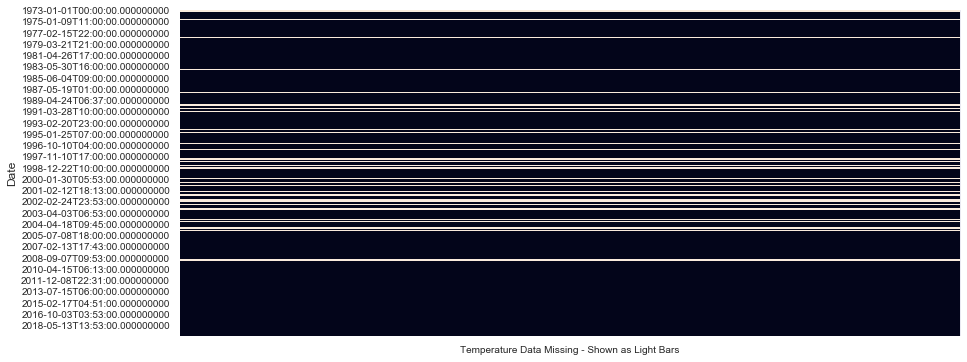

In [135]:
# Plot it
tf_hou.columns = ['Temperature Data Missing - Shown as Light Bars']
_= plt.figure(figsize=(14,6))
_= sns.heatmap(data=tf_hou,cbar=False)
_= plt.xticks(rotation=0, fontsize=10)
_= plt.yticks(rotation=0, fontsize=10)
plt.show()

Let's break this down closely by plotting the percentage of temperature values missing for each year.

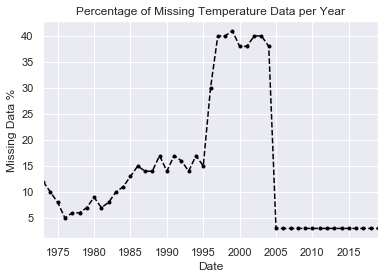

In [136]:
a=hou.count(axis=1).resample('A').sum() # non-NA's by year
b=hou.isnull().sum(axis=1).resample('A').sum() # NA's by year
c=pd.concat([a,b],axis=1) # axis=1 row direction to bind the data 
c.columns = ['non-na','na']
c['na%'] = round((c['na']/(c['non-na']+c['na']))*100)
_= c['na%'].plot(marker='.',linestyle='dashed',color='black', title='Percentage of Missing Temperature Data per Year')
_= plt.ylabel('Missing Data %')
plt.show()

It appears from the plot that during the years from 1996 to 2004, on the average, about 40% of the temperature values are missing for each of those years. The years 1973 to 1995 have anywhere from about 5% to 18% of the values missing for any particular year. Only the years 2005 to 2019 show a relatively lower amount (<5%) of missing values for each of those years.  
Another perspective on missing values, especially for the years 1996-2004, is obtained by viewing the cumulative sum of each year of the missing value counts:

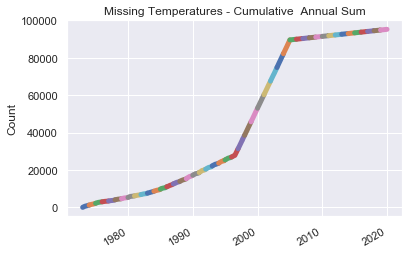

In [137]:
_= hou.isnull().cumsum(axis=0).resample('A').plot(linewidth=5)
_=plt.ylabel('Count')
_=plt.title('Missing Temperatures - Cumulative  Annual Sum')
plt.show()

As you can see in the plot above, the dramatic jump in the counts of missing data starting a little after mid-nineties time period to about the year 2005. 

For now, I am not interested in why the data is missing, but rather focus on identifying the spread of the missing data, especially for the time period 1996 to 2004.  
Understanding the spread or pattern of "missingness" can help me decide whether then to impute the data appropriately, or drop it completely from this dataset. 

A quick glance at the first and the last six temperature observations of the  dataset suggests that there is only one temperature value given per each hour of the day. 

In [138]:
hou

,DryBulbTemperature
Date,
1973-01-01 00:00:00,53.0
1973-01-01 01:00:00,52.0
1973-01-01 02:00:00,52.0
1973-01-01 03:00:00,52.0
1973-01-01 04:00:00,52.0
...,...
2019-12-31 19:53:00,49.0
2019-12-31 20:53:00,47.0
2019-12-31 21:53:00,46.0


However, looking a bit further down into the data reveals that this is not always the case. There are some hourly observations in the data set, that contains more than one temperature value given per that hour, as shown in one of the observations given below for the Hour 16 of January 2, 1991:  

In [139]:
hou.loc['1991-01-02 16']

,DryBulbTemperature
Date,
1991-01-02 16:00:00,50.0
1991-01-02 16:11:00,NaN
1991-01-02 16:19:00,NaN
1991-01-02 16:37:00,NaN
1991-01-02 16:44:00,NaN


For the Hour 16 of January 2, 1991, there is a temperature value given at Hour 16, and then there are four other observations with missing values spread out at different intervals throughout the hour.  
How many of these situations exist through out the data set, where there is temperature data missing for one or more multiple intervals of time within an hour? The good thing about this scenario of missing data, is that we can take take the maximum temperature given for that hour as the representative temperature for that hour.  So the representative temperature for the Hour 16 of January 2, 1991 is 50 F, since that is all that is available for that hour.  
Let's explore this further by looking at the overall distribution of all hourly missing values in the dataset over time.

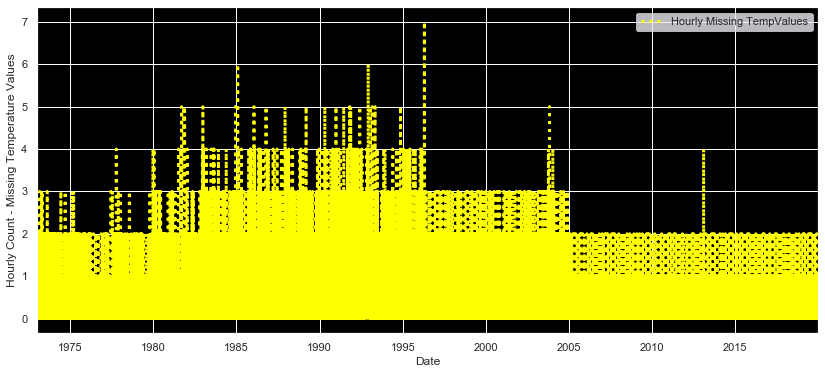

In [140]:
tf_hou.columns = ['Hourly Missing TempValues']
t_hou = tf_hou[tf_hou['Hourly Missing TempValues']==True] ## Rows with missing temperatures
missum = t_hou.resample('H').sum()
ax = missum.plot(figsize=(14,6),color='yellow',linestyle='dotted',linewidth=3)
ax.set_facecolor('black')
_= plt.ylabel('Hourly Count - Missing Temperature Values')
plt.show()

A missing value plot generated above breaks down the hourly counts of the missing data over time.  The maximum count of missing hourly data, per the plot is seven. This occurs at the Hour 16 of April 22, 1996.  

In [141]:
hou.loc['1996-04-22 16']

,DryBulbTemperature
Date,
1996-04-22 16:00:00,78.0
1996-04-22 16:01:00,NaN
1996-04-22 16:15:00,NaN
1996-04-22 16:22:00,NaN
1996-04-22 16:25:00,NaN
1996-04-22 16:31:00,NaN
1996-04-22 16:38:00,NaN
1996-04-22 16:43:00,NaN


The top five highest count of hourly missing data is:

In [142]:
missum.nlargest(5, columns='Hourly Missing TempValues')

,Hourly Missing TempValues
Date,
1996-04-22 16:00:00,7.0
1985-01-27 11:00:00,6.0
1992-12-04 02:00:00,6.0
1981-09-14 16:00:00,5.0
1981-11-05 03:00:00,5.0


Now we can re-sample this dataset by the hourly observations, with the maximum temperature for each hour given as the representative temperature of that hour.

In [143]:
houHavg = hou.resample('H').max()
houHavg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 411984 entries, 1973-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DryBulbTemperature  407241 non-null  float64
dtypes: float64(1)
memory usage: 6.3 MB


With the resampled data set of hourly maximum temperatures, we now have the number of missing temperatures at:

In [144]:
sum(houHavg['DryBulbTemperature'].isnull())

4743

We again make a plot of the missing value distribution to get the sense and location in time of its 'missingness'.

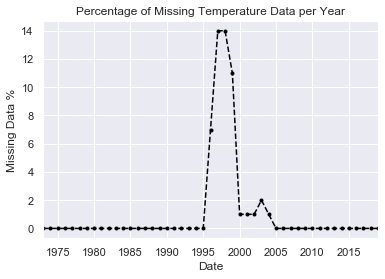

In [145]:
a=houHavg.count(axis=1).resample('A').sum() # non-NA's by year
b=houHavg.isnull().sum(axis=1).resample('A').sum() # NA's by year
c=pd.concat([a,b],axis=1) # axis=1 row direction to bind the data 
c.columns = ['non-na','na']
c['na%'] = round((c['na']/(c['non-na']+c['na']))*100)
_= c['na%'].plot(marker='.',linestyle='dashed',color='black', title='Percentage of Missing Temperature Data per Year')
_= plt.ylabel('Missing Data %')
plt.show()

The biggest percentage of the hourly temperatures missing are from years 1996 to 2004. I have generated a table below of missing data counts specifically for those years.

In [146]:
houHavg.loc['1996':'2004'].isnull().sum(axis=1).resample('A').sum()

Date
1996-12-31     627
1997-12-31    1267
1998-12-31    1269
1999-12-31     965
2000-12-31     112
2001-12-31      55
2002-12-31     100
2003-12-31     135
2004-12-31      78
Freq: A-DEC, dtype: int64

Let us look closely on a particular day in the dataset with missing hourly temperature observations - July 26, 1998:

In [147]:
houHavg.loc['1998-07-26']

,DryBulbTemperature
Date,
1998-07-26 00:00:00,80.0
1998-07-26 01:00:00,79.0
1998-07-26 02:00:00,75.0
1998-07-26 03:00:00,77.0
1998-07-26 04:00:00,76.0
1998-07-26 05:00:00,NaN
1998-07-26 06:00:00,79.0
1998-07-26 07:00:00,82.0
1998-07-26 08:00:00,87.0


This particular day has four hourly temperature measurements missing.

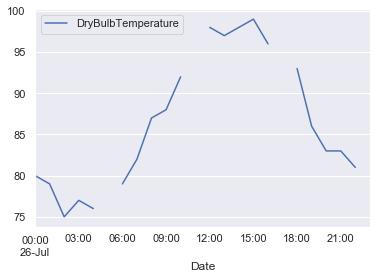

In [148]:
_=houHavg.loc['1998-07-26'].plot()

One of the methods to fill in missing values is to carry forward the last known value prior to the missing one, an approach known as "forward fill". It makes sense use the most recent known hourly measurement of temperature to fill in the missing values.  
I will use "forward fill" to fill in the missing values, then re-plot the temperatures for the day to observe the difference.

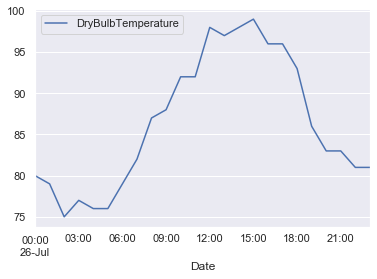

In [149]:
_= houHavg.loc['1998-07-26'].fillna(method='ffill').plot()

This will result in a plot that looks natural except where you see repeated values to account for missing data, as in the plot.  
In this case the mean temperature of the day with the forward filled values is about the same as the mean temperature of the day without forward filled values.

In [150]:
round(houHavg.loc['1998-07-26'].mean(),2) # Mean - NOT forward filled values

DryBulbTemperature    86.45
dtype: float64

In [151]:
round(houHavg.loc['1998-07-26'].fillna(method='ffill').mean(),2) # Mean - forward filled values

DryBulbTemperature    86.42
dtype: float64

I now will apply forward fill method to the fill in the rest of the missing values in the data.

In [152]:
hou = houHavg.copy()
hou = hou.fillna(method='ffill')
hou.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 411984 entries, 1973-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DryBulbTemperature  411984 non-null  float64
dtypes: float64(1)
memory usage: 6.3 MB


## Temperature Plots

In following sections, I will display the variations for the Houston's Intercontinental Airport temperatures over time in terms of:  
- Daily Maximum Temperatures  
- Daily Minimum Temperatures  
- Daily Temperature Range  
- Monthly Mean Temperatures for:  
> Winter  
> Spring  
> Summer  
> Fall  
- Decadal Maximum Daily Temperatures  
- Decadal Minimum Daily Temperatures
- Decadal Daily Temperature Range


The temperature and five-year Rolling Means plots over time shown below for both the daily maximum and minimum temperatures show rising temperatures over time in Houston.

### Daily Maximum Temperatures

In [153]:
houMaxT = hou['DryBulbTemperature'].resample('D').max()
houMaxT = pd.DataFrame(houMaxT)

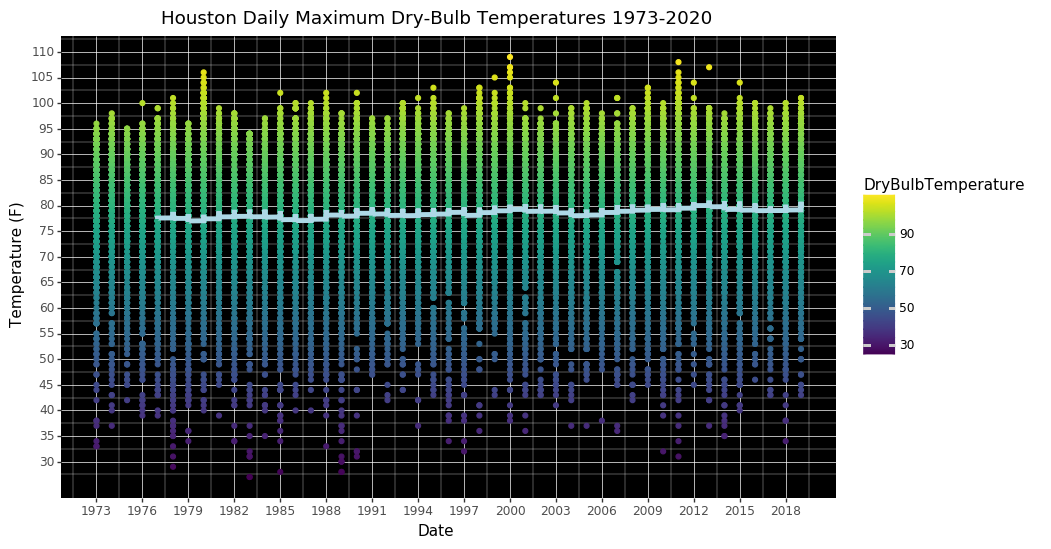

<ggplot: (123909907976)>

In [154]:
from plotnine import *
from plotnine.scales import scale_x_date, scale_y_continuous
from mizani.breaks import date_breaks, minor_breaks
from mizani.formatters import date_format
%matplotlib inline

(ggplot(houMaxT)
 + aes(x='houMaxT.index.year', y='DryBulbTemperature', color='DryBulbTemperature')
 + geom_point() 
 + labs(title='Houston Daily Maximum Dry-Bulb Temperatures 1973-2020', x='Date', y='Temperature (F)')
 + geom_smooth(size=2,color="lightblue",method = "mavg", se=False)
 + scale_x_continuous(breaks=range(1970, 2020, 3))
 + scale_y_continuous(breaks=range(30, 120, 5))
 + theme(panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = "white"), 
         panel_grid_minor = element_line(size = 0.25, linetype = 'solid',colour = "white"),
         panel_background = element_rect(fill = 'black'),
         figure_size=(10, 6)
))

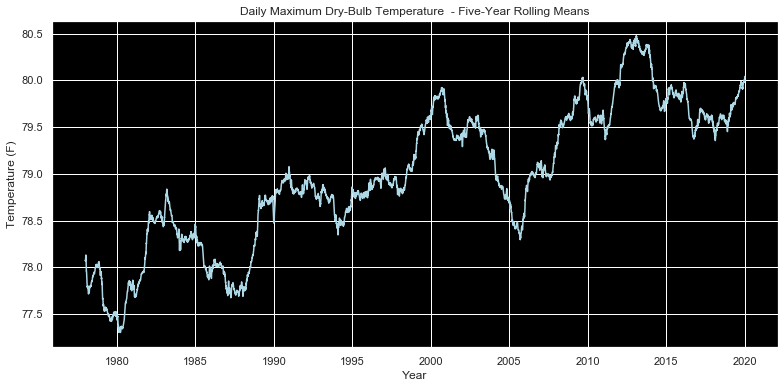

In [155]:
maMAX=houMaxT.rolling(1826).mean()
_=plt.figure(figsize=(13,6))
ax = plt.axes()
ax.set_facecolor('black')
_=plt.plot(maMAX.index,maMAX.values, color='lightblue')
_=plt.title('Daily Maximum Dry-Bulb Temperature  - Five-Year Rolling Means')
_=plt.xlabel('Year')
_=plt.ylabel('Temperature (F)')
plt.show()

### Daily Minimum Temperatures

In [156]:
houMinT = hou['DryBulbTemperature'].resample('D').min()
houMinT = pd.DataFrame(houMinT)

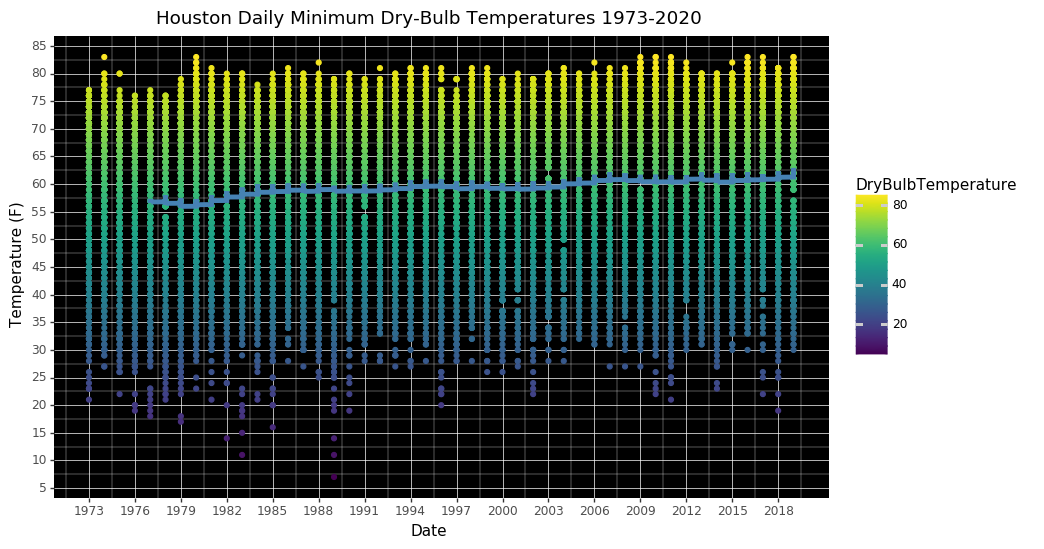

<ggplot: (-9223371912951227788)>

In [157]:
(ggplot(houMinT)
 + aes(x='houMinT.index.year', y='DryBulbTemperature', color='DryBulbTemperature')
 + geom_point() 
 + labs(title='Houston Daily Minimum Dry-Bulb Temperatures 1973-2020', x='Date', y='Temperature (F)')
 + geom_smooth(size=2,color="steelblue",method = "mavg", se=False)
 + scale_x_continuous(breaks=range(1970, 2020, 3))
 + scale_y_continuous(breaks=range(5, 90, 5))
 + theme(panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = "white"), 
         panel_grid_minor = element_line(size = 0.25, linetype = 'solid',colour = "white"),
         panel_background = element_rect(fill = 'black'),
         figure_size=(10, 6)
))

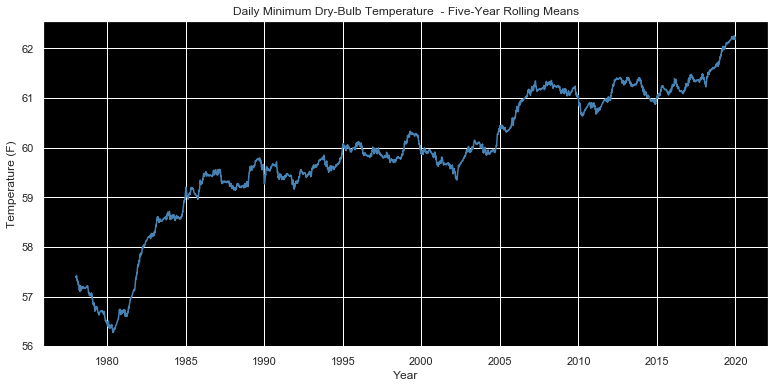

In [158]:
maMIN=houMinT.rolling(1826).mean()
_=plt.figure(figsize=(13,6))
ax = plt.axes()
ax.set_facecolor('black')
_=plt.plot(maMIN.index,maMIN.values, color='steelblue')
_=plt.title('Daily Minimum Dry-Bulb Temperature  - Five-Year Rolling Means')
_=plt.xlabel('Year')
_=plt.ylabel('Temperature (F)')
plt.show()

###  Daily Temperature Range

In [159]:
houDT = houMaxT-houMinT
houDT.columns = ['Tmax-Tmin']

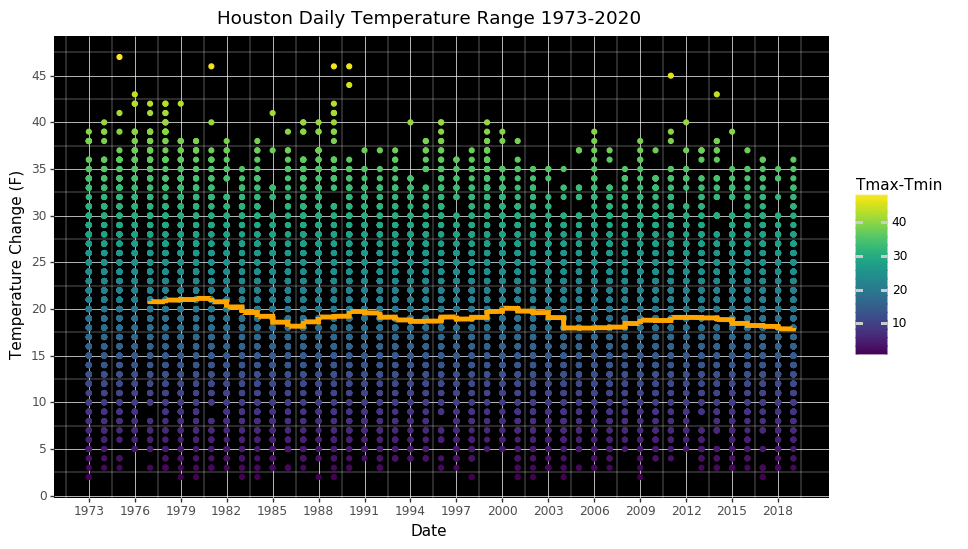

<ggplot: (123910211634)>

In [160]:
(ggplot(houDT)
 + aes(x='houDT.index.year', y='Tmax-Tmin', color='Tmax-Tmin')
 + geom_point() 
 + labs(title='Houston Daily Temperature Range 1973-2020', x='Date', y='Temperature Change (F)')
 + geom_smooth(size=2,color="Orange",method = "mavg", se=False)
 + scale_x_continuous(breaks=range(1970, 2020, 3))
 + scale_y_continuous(breaks=range(0, 50, 5))
 + theme(panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = "white"), 
         panel_grid_minor = element_line(size = 0.25, linetype = 'solid',colour = "white"),
         panel_background = element_rect(fill = 'black'),
         figure_size=(10, 6)
))

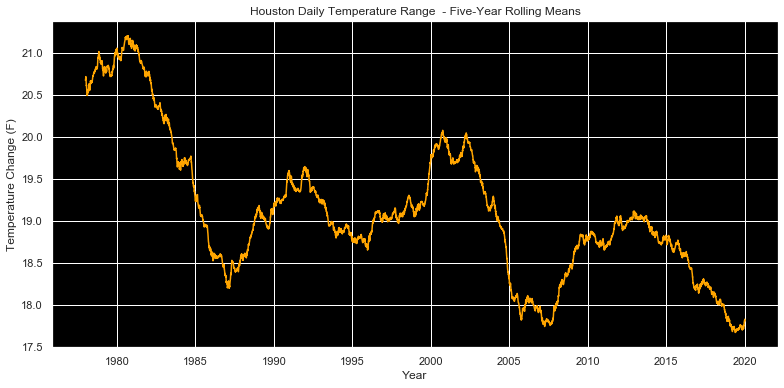

In [161]:
maDT=houDT.rolling(1826).mean()
_=plt.figure(figsize=(13,6))
ax = plt.axes()
ax.set_facecolor('black')
_=plt.plot(maDT.index,maDT.values, color='orange')
_=plt.title('Houston Daily Temperature Range  - Five-Year Rolling Means')
_=plt.xlabel('Year')
_=plt.ylabel('Temperature Change (F)')
plt.show()

Daily temperature range, which is the difference between the maximum and minimum temperature for a given day, is getting smaller over time.  
As shown in the respective plots shown earlier, both the daily maximum and minimum temperatures seem to be rising over Houston in time. However, the rate of daily minimum temperature is rising at a higher rate than the daily maximum temperature. This explains why the plot above shows the difference between daily maximum and minimum temps are lowering over time.

 ### Variation of  Mean Seasonal Monthly Temperatures over Time

Monthly plots segregated by seasons are generated below. Overall, I see the monthly temperatures increasing over the years.

In [162]:
houMon = hou['DryBulbTemperature'].resample('M').mean()

#### Winter Months

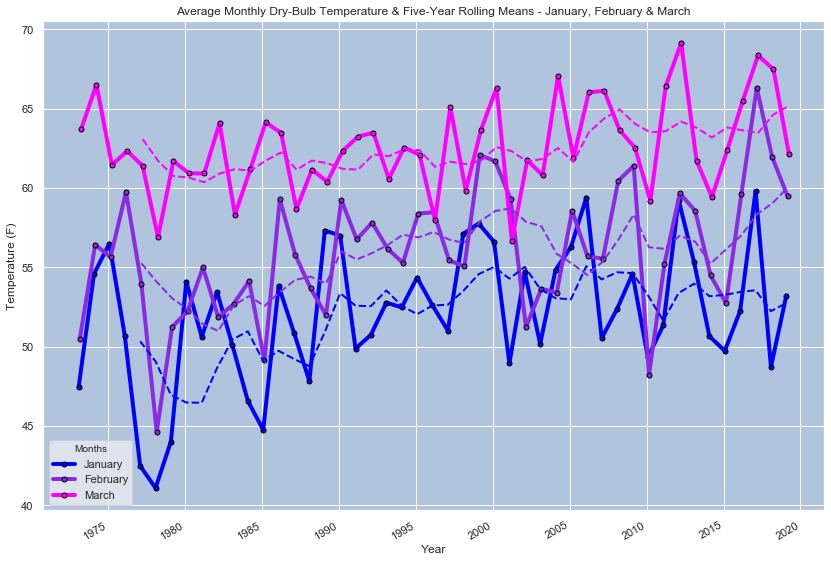

In [163]:
_= plt.figure(figsize=(14,10))
ax = plt.axes()
ax.set_facecolor('lightsteelblue')
colors=['blue','blueviolet','magenta']
for i in range(1,4):
    _=plt.plot(houMon[houMon.index.month==i].index,houMon[houMon.index.month==i],label=i,linewidth=4,color=colors[i-1],
              marker='o',markersize=5,markerfacecolor=colors[i-1],
         markeredgecolor='black')
    
labels = ['January', 'February', 'March']
_=plt.legend(labels,title="Months",loc=1)    

for i in range(1,4):
    # Compute the five year rolling means 
    ma = houMon[houMon.index.month==i].rolling(window=5).mean()
    _=ma.plot(linewidth=2, color=colors[i-1],linestyle='dashed',legend=False)

_= plt.title("Average Monthly Dry-Bulb Temperature & Five-Year Rolling Means - January, February & March")
_= plt.xlabel('Year')
_= plt.ylabel('Temperature (F)')


plt.show()    

#### Spring Months

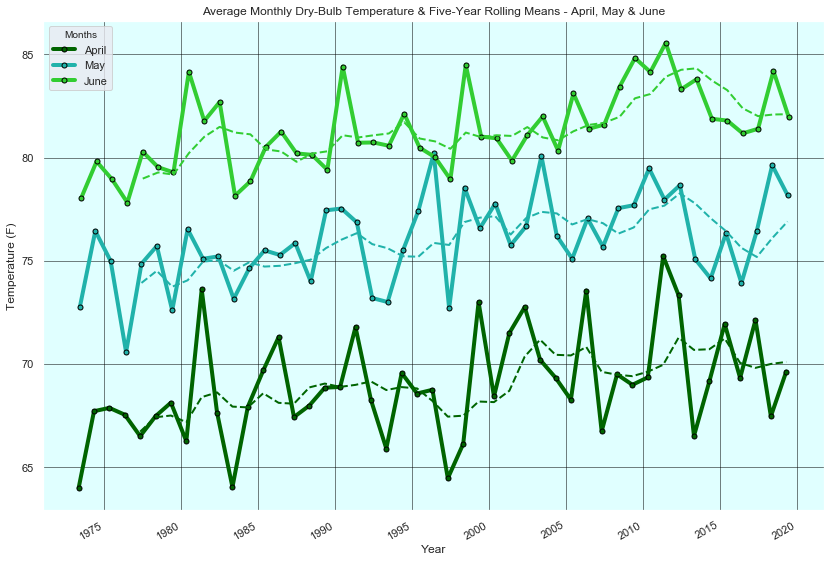

In [164]:
_= plt.figure(figsize=(14,10))
ax = plt.axes()
ax.set_facecolor('lightcyan')
colors=['darkgreen','lightseagreen','limegreen']
for i in range(4,7):
    _=plt.plot(houMon[houMon.index.month==i].index,houMon[houMon.index.month==i],label=i,linewidth=4,color=colors[i-4],
              marker='o',markersize=5,markerfacecolor=colors[i-4],
         markeredgecolor='black')

_= plt.grid(axis='both',linewidth=0.5, color='black', linestyle='-')
labels = ['April', 'May', 'June']
_=plt.legend(labels,title="Months",loc=1)    

for i in range(4,7):
    # Compute the five year rolling means 
    ma = houMon[houMon.index.month==i].rolling(window=5).mean()
    _=ma.plot(linewidth=2, color=colors[i-4],linestyle='dashed',legend=False)

    
_= plt.title("Average Monthly Dry-Bulb Temperature & Five-Year Rolling Means - April, May & June")
_= plt.xlabel('Year')
_= plt.ylabel('Temperature (F)')

plt.show()    

#### Summer Months

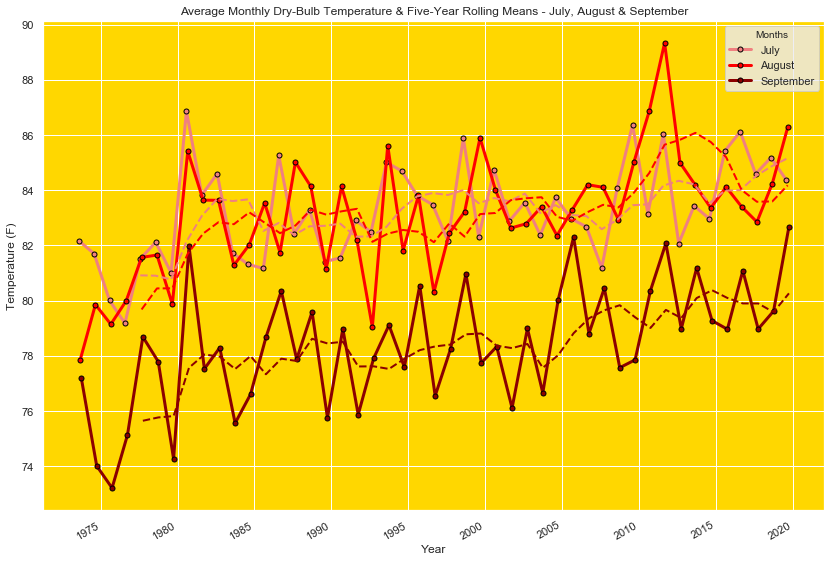

In [165]:
_= plt.figure(figsize=(14,10))
ax = plt.axes()
ax.set_facecolor('gold')
colors=['lightcoral','red','darkred']
for i in range(7,10):
    _=plt.plot(houMon[houMon.index.month==i].index,houMon[houMon.index.month==i],label=i,linewidth=3,color=colors[i-7],
              marker='o',markersize=5,markerfacecolor=colors[i-7],
         markeredgecolor='black')
labels = ['July', 'August', 'September']
_=plt.legend(labels,title="Months",loc=1) 

for i in range(7,10):
    # Compute the five year rolling means 
    ma = houMon[houMon.index.month==i].rolling(window=5).mean()
    _=ma.plot(linewidth=2, color=colors[i-7],linestyle='dashed',legend=False)

_= plt.title("Average Monthly Dry-Bulb Temperature & Five-Year Rolling Means - July, August & September")
_= plt.xlabel('Year')
_= plt.ylabel('Temperature (F)')

plt.show()    

#### Fall Months

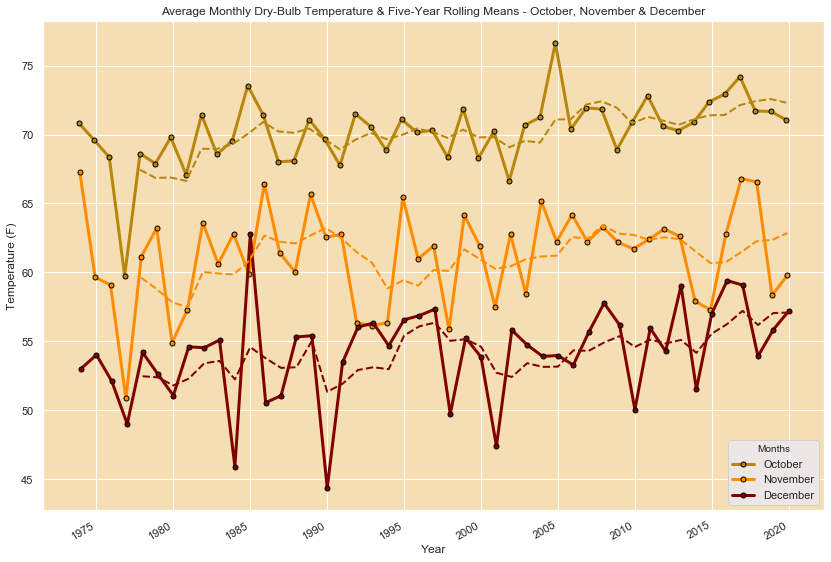

In [166]:
_= plt.figure(figsize=(14,10))
ax = plt.axes()
ax.set_facecolor('wheat')
colors=['darkgoldenrod','darkorange','maroon']
for i in range(10,13):
    _=plt.plot(houMon[houMon.index.month==i].index,houMon[houMon.index.month==i],label=i,linewidth=3,color=colors[i-10],
              marker='o',markersize=5,markerfacecolor=colors[i-10],
         markeredgecolor='black')
labels = ['October', 'November', 'December']
_=plt.legend(labels,title="Months",loc=1) 

for i in range(10,13):
    # Compute the five year rolling means 
    ma = houMon[houMon.index.month==i].rolling(window=5).mean()
    _=ma.plot(linewidth=2, color=colors[i-10],linestyle='dashed',legend=False)

_= plt.title("Average Monthly Dry-Bulb Temperature & Five-Year Rolling Means - October, November & December")
_= plt.xlabel('Year')
_= plt.ylabel('Temperature (F)')

_=plt.legend(labels,title="Months",loc=4)
plt.show()    

### Variations of Daily Temperatures at Decadal  Intervals

In [167]:
def decades(df):
    '''A function to subset temp data by decades'''
    the1970s = df.loc['1973':'1979','DryBulbTemperature']
    the1980s = df.loc['1980':'1989','DryBulbTemperature']
    the1990s = df.loc['1990':'1999','DryBulbTemperature']
    the2000s = df.loc['2000':'2009','DryBulbTemperature']
    the2010s = df.loc['2010':'2019','DryBulbTemperature']
    temps=[the1970s,the1980s,the1990s,the2000s,the2010s]
    label=['the1970s','the1980s','the1990s','the2000s','the2010s']
    
    return temps, label

#### Maximum Daily Temperature Decadal Variations

In [168]:
# subset max daily temp data by decades
temps, label = decades(houMaxT)

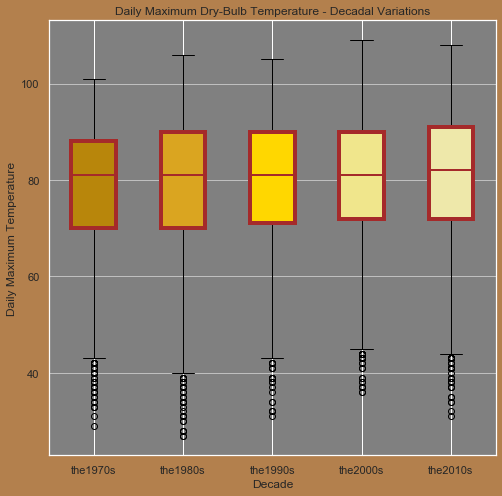

In [169]:
_= plt.figure(figsize=(8,8),facecolor=(.7,.5,.3))
ax = plt.axes()
# Setting the background color
ax.set_facecolor("grey")

boxprops = dict(linestyle='-', linewidth=4, color='brown')
medianprops = dict(linestyle='-', linewidth=2, color='brown')
box=plt.boxplot(temps, vert=True, patch_artist=True, labels=label,boxprops=boxprops,medianprops=medianprops)
_= plt.grid(axis='y',linewidth=0.5, color='white', linestyle='-')
_= plt.xlabel('Decade')
_= plt.ylabel('Daily Maximum Temperature')
_= plt.title('Daily Maximum Dry-Bulb Temperature - Decadal Variations')
colors = ['darkgoldenrod', 'goldenrod', 'gold', 'khaki','palegoldenrod']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

In [170]:
# Daily max temperature medians & means by decades
la=[lab for lab in label]
teMD=[np.median(t) for t in temps]
teMN=[round(np.mean(t),1) for t in temps]
maxT=pd.DataFrame(list(zip(teMD,teMN)),columns=['Median Daily Max Temp','Mean Daily Max Temp'],index=la)
maxT

,Median Daily Max Temp,Mean Daily Max Temp
the1970s,81.0,77.7
the1980s,81.0,78.5
the1990s,81.0,79.2
the2000s,81.0,79.2
the2010s,82.0,79.9


Overall, the mean daily maximum temperature for each decade seems to be ever so slightly increasing from the 1970's on forward.

#### Minimum Daily Temperature Decadal Variations

In [171]:
# subset min daily temp data by decades
temps, label = decades(houMinT)

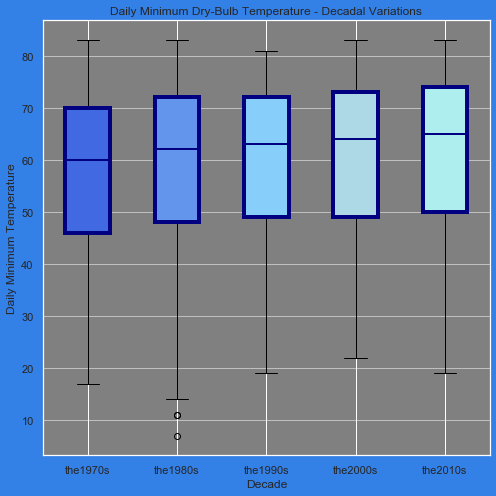

In [172]:
_= plt.figure(figsize=(8,8),facecolor=(.2,.5,.9))
ax = plt.axes()
# Setting the background color
ax.set_facecolor("grey")

boxprops = dict(linestyle='-', linewidth=4, color='navy')
medianprops = dict(linestyle='-', linewidth=2, color='navy')
box=plt.boxplot(temps, vert=True, patch_artist=True, labels=label,boxprops=boxprops,medianprops=medianprops)
_= plt.grid(axis='y',linewidth=0.5, color='white', linestyle='-')
_= plt.xlabel('Decade')
_= plt.ylabel('Daily Minimum Temperature')
_= plt.title('Daily Minimum Dry-Bulb Temperature - Decadal Variations')
colors = ['royalblue', 'cornflowerblue', 'lightskyblue', 'lightblue','paleturquoise']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

In [173]:
# Daily min temperature medians & means by decades
la=[lab for lab in label]
teMD=[np.median(t) for t in temps]
teMN=[round(np.mean(t),1) for t in temps]
minT = pd.DataFrame(list(zip(teMD,teMN)),columns=['Median Daily Min Temp','Mean Daily Min Temp'],index=la)
minT

,Median Daily Min Temp,Mean Daily Min Temp
the1970s,60.0,57.1
the1980s,62.0,59.2
the1990s,63.0,60.0
the2000s,64.0,60.7
the2010s,65.0,61.6


The daily minimum temperature mean and medians are higher for each of the subsequent decades from the 1970's forward.  
It looks like the daily minimum temperatures are rising faster over time compared to the daily maximum temperatures.

#### Daily Temperature Decadal Range Variations

In [174]:
# Combine the Daily Max and Min statistics into a single dataframe
rangeT = pd.concat([maxT,minT],axis=1)
rangeT['Mean Daily Temp Variation'] = rangeT['Mean Daily Max Temp'] - rangeT['Mean Daily Min Temp']
rangeT

,Median Daily Max Temp,Mean Daily Max Temp,Median Daily Min Temp,Mean Daily Min Temp,Mean Daily Temp Variation
the1970s,81.0,77.7,60.0,57.1,20.6
the1980s,81.0,78.5,62.0,59.2,19.3
the1990s,81.0,79.2,63.0,60.0,19.2
the2000s,81.0,79.2,64.0,60.7,18.5
the2010s,82.0,79.9,65.0,61.6,18.3


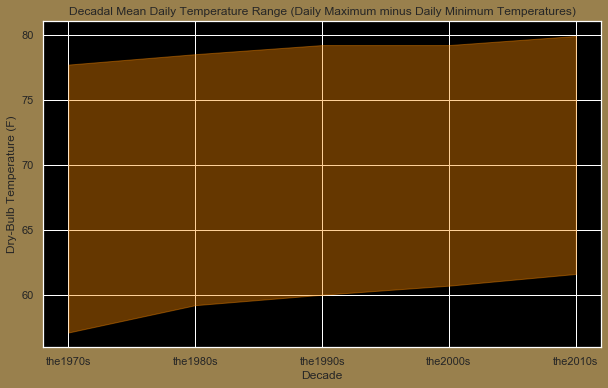

In [175]:
_= plt.figure(figsize=(10,6),facecolor=(.6,.5,.3))
# Setting the background color
ax = plt.axes()
ax.set_facecolor("black")
_= plt.fill_between(rangeT.index, rangeT['Mean Daily Max Temp'],rangeT['Mean Daily Min Temp'], color='darkorange',alpha=0.4)
_= plt.title('Decadal Mean Daily Temperature Range (Daily Maximum minus Daily Minimum Temperatures)')
_= plt.xlabel('Decade')
_= plt.ylabel('Dry-Bulb Temperature (F)')
plt.show()

The difference between the daily maximum and minimum temperatures is getting smaller over the decades. This plot confirms the plot from before that showed the daily minimum temperatures are rising faster over time compared to the daily maximum temperatures.

### Spring Hourly Temperatures - Decadal Intervals

Here, I am going to look at the temperature variations over the decades for the spring season, and to see if there any perceptible shifts in the hourly Dry-Bulb temperatures over the five decades.  
Spring is defined here as the months covering April, May and June.

In [176]:
# subset hourly temperature data by decades
temps, label = decades(hou)

In [177]:
# Decadal hourly spring (April, May, June) temperatures
spring1970s=pd.concat((temps[0][temps[0].index.month==4],
                       temps[0][temps[0].index.month==5],
                       temps[0][temps[0].index.month==6])).sort_index()
spring1980s=pd.concat((temps[1][temps[1].index.month==4],
                       temps[1][temps[1].index.month==5],
                       temps[1][temps[1].index.month==6])).sort_index()
spring1990s=pd.concat((temps[2][temps[2].index.month==4],
                       temps[2][temps[2].index.month==5],
                       temps[2][temps[2].index.month==6])).sort_index()
spring2000s=pd.concat((temps[3][temps[3].index.month==4],
                       temps[3][temps[3].index.month==5],
                       temps[3][temps[3].index.month==6])).sort_index()
spring2010s=pd.concat((temps[4][temps[4].index.month==4],
                       temps[4][temps[4].index.month==5],
                       temps[4][temps[4].index.month==6])).sort_index()

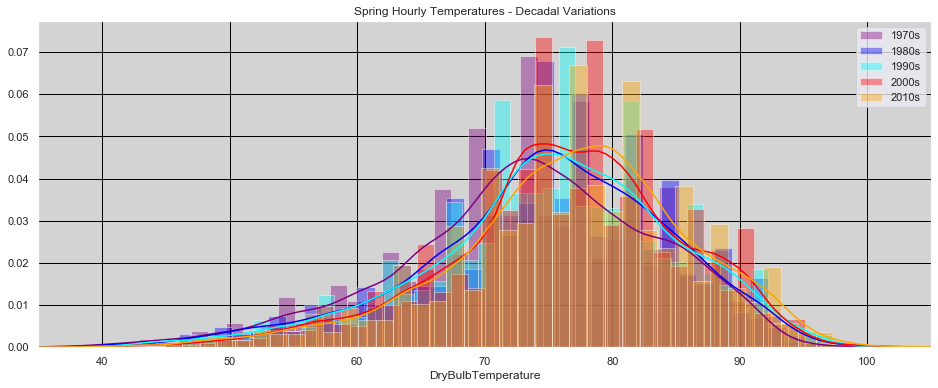

In [178]:
_=plt.figure(figsize=(16,6))
ax = plt.axes()
ax.set_facecolor('lightgrey')
_=plt.xlim(35,105)
_=sns.distplot(spring1970s,color='purple',label='1970s')
_=sns.distplot(spring1980s,color='blue',label='1980s')
_=sns.distplot(spring1990s,color='cyan',label='1990s')
_=sns.distplot(spring2000s,color='red',label='2000s')
_=sns.distplot(spring2010s,color='orange',label='2010s')
_=plt.title('Spring Hourly Temperatures - Decadal Variations')
_=plt.grid(color='black')
_=plt.legend()
plt.show()

The plot displayed above gives a univariate distribution of the Spring hourly temperature observations differentiated by the decades from 1970's to the 2010's.  
As the decades progress from the 1970's forward, I see a shift of the distribution curves towards increasing temperatures. This is more evident in the tails of the distribution curves. On the lower temperatures portions of the plot, the purples and blues depicting past decades dominate the area of temperature distribution, while the higher temperature distributions of reds and oranges seem to occupy the more recent decades.

## Empirical cumulative distribution function (ECDF)

"In statistics, an empirical distribution function is the distribution function associated with the empirical measure of a sample. This cumulative distribution function is a step function that jumps up by 1/n at each of the n data points. Its value at any specified value of the measured variable is the fraction of observations of the measured variable that are less than or equal to the specified value." - Wikipedia  
ECDF models empirical (i.e. observed) data. The ECDF is the probability distribution you would get if you sampled from your sample, instead of the population.

In [179]:
# Create a ECDF function
import numpy as np
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

### Hourly Temperature ECDFs  Decadal Variations

In [180]:
# Compute ECDFs
x_70, y_70 = ecdf(temps[0])
x_80, y_80 = ecdf(temps[1])
x_90, y_90 = ecdf(temps[2])
x_20, y_20 = ecdf(temps[3])
x_21, y_21 = ecdf(temps[4])

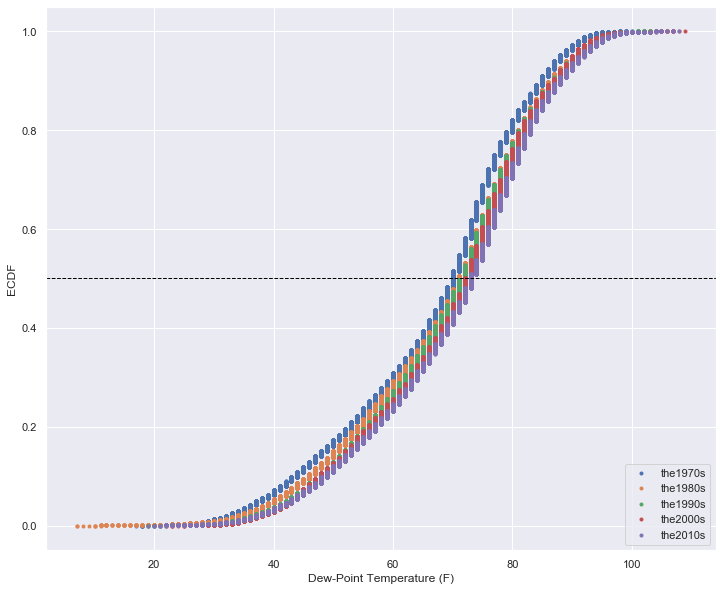

In [181]:
# Plot all ECDFs on the same plot
_= plt.figure(figsize=(12,10))
_= plt.plot(x_70, y_70, marker='.', linestyle='none')
_= plt.plot(x_80, y_80, marker='.', linestyle='none')
_= plt.plot(x_90, y_90, marker='.', linestyle='none')
_= plt.plot(x_20, y_20, marker='.', linestyle='none')
_= plt.plot(x_21, y_21, marker='.', linestyle='none')

# Annotate the plot
_=plt.legend(('the1970s', 'the1980s', 'the1990s','the2000s','the2010s'), loc='lower right')
_ = plt.xlabel('Dew-Point Temperature (F)')
_ = plt.ylabel('ECDF')

_= plt.axhline(0.5, ls='--', linewidth=1, color='black') # horizontal dashed line through the 50 percentile distribution

# Display the plot
plt.show()

Five ECDF plots of hourly temperatures, differentiated by each decade from the 1970's forward, is shown above. They show a shift towards higher temperatures over time.  
A close-up of this ECDF plot is generated below to obtain an enhanced view of the 50th-percentile temperatures over the decades.

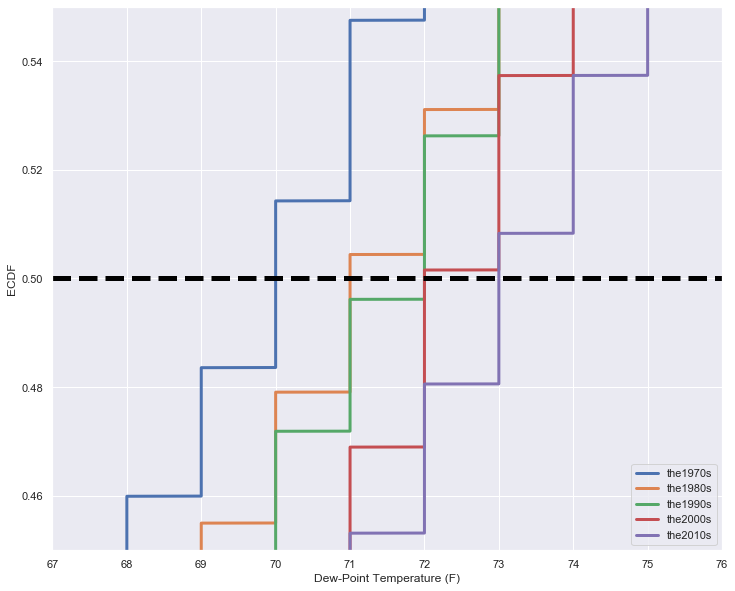

In [182]:
# Plot all ECDFs on the same plot
_= plt.figure(figsize=(12,10))
_= plt.plot(x_70, y_70,linewidth=3)
_= plt.plot(x_80, y_80,linewidth=3)
_= plt.plot(x_90, y_90,linewidth=3)
_= plt.plot(x_20, y_20,linewidth=3)
_= plt.plot(x_21, y_21,linewidth=3)

# Annotate the plot
_=plt.legend(('the1970s', 'the1980s', 'the1990s','the2000s','the2010s'), loc='lower right')
_ = plt.xlabel('Dew-Point Temperature (F)')
_ = plt.xlim(67,76)
_ = plt.ylim(0.45,0.55)
_ = plt.ylabel('ECDF')

_= plt.axhline(0.5, ls='--', linewidth=5, color='black') # horizontal dashed line through the 50 percentile distribution

# Display the plot
plt.show()

I drew a line across the 50th percentile mark to highlight the crossing points of each of the five ecdfs at the 50th-percentile mark. So here in this plot you can see that for each of the five decades plotted:  
- In the 1970's, 50% of the hourly temperatures were 70 F or lower  
- 1980's, 50% of the hourly temperatures were 71 F or lower  
- 1990's, 50% of the hourly temperatures were 72 F or lower  
- 2000's, 50% of the hourly temperatures were 72 F or lower  
- 2010's, 50% of the hourly temperatures were 73 F or lower  

Therefore, what this means is that within the 50th-percentiles, for each of the decade since the seventies, contain increasingly higher temperatures. This translates to a rising trend of hourly temperatures over time.

## Conclusions

Every plot visual of Houston climate temperatures in all of it's temporal flavors that I had generated above, tells me that my spring time ruminations about the overall warmer weather, that I am experiencing this spring fits a trend towards rising temperatures here in Houston. It's also seen here in this EDA, that this rising temperature trend holds not just for the spring season, but for all the other seasons as well.  

Although, for today, Houston is gifted with the perfect Chamber of Commerce weather - cool, dry and sunny. However, I am beginning to see less of these type of days in the spring. It seems like the last few years, summer is knocking on the door of spring a bit too earlier to come in.  

Regardless, I am going to thank the weather gods for today's splendid day, by stepping outside my office and taking it all in.  

Happy Spring!!!
